# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def output_size(w,k,p,s):
    '''
    Calculates the output size of a convolution/pooling layer.
    - w [int]: input volume
    - k [int]: Kernel size
    - p [int]: padding
    - s [int]: stride
    '''
    return ((w-k+2*p)/s)+1

# Intro

## CNN Architecture

- Conv layer - 6 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Conv layer - 16 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Fully connected - 46,656* > 120 > 84 > 2
*See calculation below

In [3]:
# Calculating fully connected layers input
c1 = output_size(224,3,0,1)
p1 = output_size(c1,2,0,2)
c2 = output_size(p1,3,0,1)
p2 = output_size(c2,2,0,2)

print(f'C1: {c1} > P1: {p1} > C2: {c2} > P2: {p2} = {int(p2)} pixels per side')
print(f'Fully connected layers inputs = {int(p2)**2*16:,} > {int(p2)} pixels squared x number of channels')

C1: 222.0 > P1: 111.0 > C2: 109.0 > P2: 54.5 = 54 pixels per side
Fully connected layers inputs = 46,656 > 54 pixels squared x number of channels


# Transforms

We will be creating two transform objects, one for train data, and one for test data. 

In [4]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

Images do not need to be augmented in the test set. 

In [5]:
test_transfrom = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Data sets and loaders

Loading the data can be done with the `datasets.ImageFolder` class.

In [6]:
root = '../Data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=train_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True,num_workers=3)
test_loader = DataLoader(test_data,batch_size=10,shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data):,}')
print(f'Testing images available:  {len(test_data):,}')

['CAT', 'DOG']
Training images available: 18,743
Testing images available:  6,251


# Reviewing data

In [7]:
# Grab the first batch of images
for images, labels in train_loader:
    break

In [8]:
# Print labels and classes
print(f'labels:\n{labels.numpy().reshape(2,-1)}')
print(f'classes:\n{np.array([class_names[i] for i in labels.numpy()]).reshape(2,-1)}')

labels:
[[1 1 0 0 1]
 [1 0 1 0 0]]
classes:
[['DOG' 'DOG' 'CAT' 'CAT' 'DOG']
 ['DOG' 'CAT' 'DOG' 'CAT' 'CAT']]


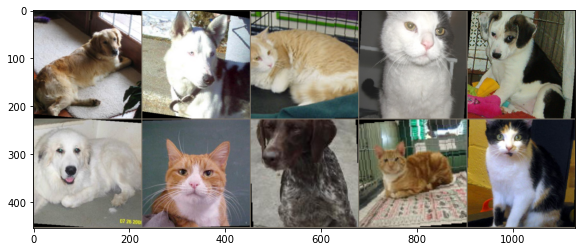

In [9]:
# Visualise images
im = make_grid(images,nrow=5)
inv_norm = transforms.Normalize([-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                [1/0.229,1/0.224,1/0.225])

inv_im = inv_norm(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(inv_im.numpy(),(1,2,0)))

# Defining the model

In [10]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54**2*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        # Data needs to be flattened before ran into the linear layers
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

- Conv layer - 6 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Conv layer - 16 filters, 3x3 size, stride 1
- Pooling layer - 2x2 size, stride 2
- Fully connected - 46,656* > 120 > 84 > 2

In [11]:
# Initialise our model
CNNmodel = ConvolutionalNetwork()

In [12]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

## Loss and optimisation functions

In [13]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

## Parameter calculation

In [14]:
n_param = 0
for param in CNNmodel.parameters():
    print(f'{param.numel():10,}')
    n_param += param.numel()
print(f'----------\n{n_param:10,}')

       162
         6
       864
        16
 5,598,720
       120
    10,080
        84
       168
         2
----------
 5,610,222


# Training

In [15]:
start_time = time.time()

epochs = 4
train_correct = []
train_loss = []
train_batch_loss = []
train_batch_corr = []
test_correct = []
test_loss = []

# Limit the number of batches for code testing purposes
#max_batch = 2

for e in range(epochs):
    trn_corr = 0

    # Training batches    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        #if b>=max_batch:
        #   break
        b+=1
        
        # Prediction per batch
        y_pred = CNNmodel(X_train)
        # Loss per batch
        loss = criterion(y_pred, y_train)
        
        # Check batch prediction
        pred = torch.max(y_pred.data,dim=1)[1]
        batch_corr = (pred==y_train).sum()
        trn_corr += batch_corr
        train_batch_loss.append(loss)
        train_batch_corr.append(trn_corr)
        
        # Update parameters
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        # Print the results
        if b%200==0:
            print(f'Epoch: {e+1:3}\tBatch: {e+1:3}-{b:4}[{b*10:5,}/{len(train_data):,}]\tLoss: {loss.item():8.5f}\tAccuracy: {trn_corr/(b*10):8.5f}')
        
    train_correct.append(trn_corr)
    train_loss.append(loss)

    # Run the testing batches
    tst_corr = 0

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            #if b>=max_batch:
            #    break
            
            # Prediction
            y_val = CNNmodel(X_test)
        
            # Check prediction
            pred = torch.max(y_val.data,dim=1)[1]
            batch_corr = (pred==y_test).sum()
            tst_corr += batch_corr
        
    # Loss for epoch
    loss = criterion(y_val, y_test)
    test_loss.append(loss)
    test_correct.append(tst_corr)

# Print duration
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:   1	Batch:   1- 200[2,000/18,743]	Loss:  0.64005	Accuracy:  0.56600
Epoch:   1	Batch:   1- 400[4,000/18,743]	Loss:  0.55587	Accuracy:  0.59725


/Users/adgb/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch:   1	Batch:   1- 600[6,000/18,743]	Loss:  0.65016	Accuracy:  0.61883
Epoch:   1	Batch:   1- 800[8,000/18,743]	Loss:  0.47379	Accuracy:  0.62900
Epoch:   1	Batch:   1-1000[10,000/18,743]	Loss:  0.49082	Accuracy:  0.64260
Epoch:   1	Batch:   1-1200[12,000/18,743]	Loss:  0.56337	Accuracy:  0.65058
Epoch:   1	Batch:   1-1400[14,000/18,743]	Loss:  0.44747	Accuracy:  0.66000
Epoch:   1	Batch:   1-1600[16,000/18,743]	Loss:  0.47956	Accuracy:  0.66725
Epoch:   1	Batch:   1-1800[18,000/18,743]	Loss:  0.57063	Accuracy:  0.67178
Epoch:   2	Batch:   2- 200[2,000/18,743]	Loss:  0.69261	Accuracy:  0.73250
Epoch:   2	Batch:   2- 400[4,000/18,743]	Loss:  0.51138	Accuracy:  0.74050
Epoch:   2	Batch:   2- 600[6,000/18,743]	Loss:  0.42398	Accuracy:  0.73717
Epoch:   2	Batch:   2- 800[8,000/18,743]	Loss:  0.39390	Accuracy:  0.74112
Epoch:   2	Batch:   2-1000[10,000/18,743]	Loss:  0.73716	Accuracy:  0.74560
Epoch:   2	Batch:   2-1200[12,000/18,743]	Loss:  0.43809	Accuracy:  0.74667
Epoch:   2	Batch: 

/Users/adgb/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch:   2	Batch:   2-1600[16,000/18,743]	Loss:  0.66373	Accuracy:  0.75238
Epoch:   2	Batch:   2-1800[18,000/18,743]	Loss:  0.43931	Accuracy:  0.75394
Epoch:   3	Batch:   3- 200[2,000/18,743]	Loss:  0.34979	Accuracy:  0.77350
Epoch:   3	Batch:   3- 400[4,000/18,743]	Loss:  0.35362	Accuracy:  0.77325
Epoch:   3	Batch:   3- 600[6,000/18,743]	Loss:  0.67342	Accuracy:  0.77100
Epoch:   3	Batch:   3- 800[8,000/18,743]	Loss:  0.45204	Accuracy:  0.77075
Epoch:   3	Batch:   3-1000[10,000/18,743]	Loss:  0.28035	Accuracy:  0.77290
Epoch:   3	Batch:   3-1200[12,000/18,743]	Loss:  0.66499	Accuracy:  0.77400
Epoch:   3	Batch:   3-1400[14,000/18,743]	Loss:  0.29157	Accuracy:  0.77450
Epoch:   3	Batch:   3-1600[16,000/18,743]	Loss:  0.31027	Accuracy:  0.77425


/Users/adgb/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch:   3	Batch:   3-1800[18,000/18,743]	Loss:  0.52898	Accuracy:  0.77533
Epoch:   4	Batch:   4- 200[2,000/18,743]	Loss:  0.59051	Accuracy:  0.80300
Epoch:   4	Batch:   4- 400[4,000/18,743]	Loss:  0.27298	Accuracy:  0.81125


/Users/adgb/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch:   4	Batch:   4- 600[6,000/18,743]	Loss:  0.56790	Accuracy:  0.80283
Epoch:   4	Batch:   4- 800[8,000/18,743]	Loss:  0.34922	Accuracy:  0.80375
Epoch:   4	Batch:   4-1000[10,000/18,743]	Loss:  0.42859	Accuracy:  0.80030
Epoch:   4	Batch:   4-1200[12,000/18,743]	Loss:  0.29144	Accuracy:  0.79883
Epoch:   4	Batch:   4-1400[14,000/18,743]	Loss:  0.67692	Accuracy:  0.79764
Epoch:   4	Batch:   4-1600[16,000/18,743]	Loss:  0.67299	Accuracy:  0.79887
Epoch:   4	Batch:   4-1800[18,000/18,743]	Loss:  0.43608	Accuracy:  0.79911

Duration: 4131 seconds


## Save trained model

In [16]:
torch.save(CNNmodel.state_dict(),f'model_files/04-CNN-CustomData-{epochs}e.pt')

# Model Evaluation

In [17]:
# Convert losses to numpy arrays
train_loss_np = np.array([i.data for i in train_loss])
test_loss_np = np.array([i.data for i in test_loss])

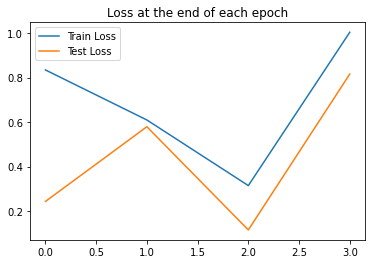

In [18]:
# Plot loss at end of epoch
plt.plot(train_loss_np,label='Train Loss')
plt.plot(test_loss_np, label='Test Loss')
plt.legend()
plt.title('Loss at the end of each epoch');

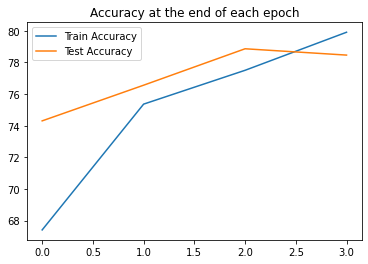

In [19]:
plt.plot(np.array([i.data for i in train_correct])/18743*100,label='Train Accuracy')
plt.plot(np.array([i.data for i in test_correct])/6251*100,label='Test Accuracy')
plt.legend()
plt.title('Accuracy at the end of each epoch');
